In [7]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import plotly.express as px

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

Below data sources are used:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. We will be looking only look at GDP data from the first quarter of 2000 onward.



## Get list of university towns

1. For "State", remove characters from "[" to the end.
2. For "RegionName", when applicable, removing every character from " (" to the end.
3. Remove newline character '\n'. 

In [9]:

states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [10]:
states2 = {}
for k,v in states.items():
    states2[v] = k
#states2

In [11]:
city_homes = pd.read_csv("City_Zhvi_AllHomes.csv")
city_homes.head()

,RegionID,RegionName,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
0,6181,New York,NY,New York,Queens,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,432600.0,438700.0,440500.0,433900.0,422000.0,415700.0,421200.0,431100.0,435100.0,431900.0,428400.0,430700.0,438800.0,446800.0,455400.0,465500.0,472600.0,478200.0,487600.0,498600.0,508800.0,515300.0,517000.0,517800.0,520800.0,521500.0,523000.0,526300.0,524800.0,519100.0,516200.0,516400.0,516300.0,515500.0,512200.0,509200.0,509800.0,511600.0,512700.0,514000.0,513400.0,510700.0,508100.0,506700.0,505200.0,503700.0,502900.0,502400.0,500500.0,496400.0,491900.0,487500.0,484400.0,481700.0,477900.0,473600.0,469700.0,466100.0,461700.0,457700.0,455300.0,454800.0,456000.0,457800.0,461300.0,466100.0,470200.0,472800.0,475300.0,477100.0,478400.0,479100.0,478900.0,477700.0,476700.0,477100.0,478000.0,478000.0,476800.0,475300.0,473800.0,472000.0,470600.0,469900.0,469500.0,468200.0,465800.0,463500.0,461800.0,460100.0,459700.0,460800.0,461700.0,462500.0,463900.0,466000.0,467500.0,468200.0,468700.0,469400.0,469400,469100.0,468700,469300,470300,472100,474300,477600,481400,485100,488800,492600,495900,499500,503500,506400,509900,515700,520800,522200,522400,523800,526200,528400,529600,530800,532200,533800,536200,540600,545600,551400,557200,563000,568700,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
1,12447,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2,155000.0,154600.0,154400.0,154200.0,154100.0,154300.0,154300.0,154200.0,154800.0,155900.0,157000.0,157700.0,158200.0,158600.0,158800.0,158900.0,159100.0,159800.0,160700.0,161900.0,163400.0,165400.0,167000.0,168500.0,169900.0,171400.0,172900.0,174300.0,175800.0,1778

In [12]:
with open("C:\\Users\\Benson\\PythonScripts\\pandas\\UniversityMichigan_DataScience\\university_towns.txt") as f:
    lines = f.readlines()

In [11]:
lines[:15]

['Alabama[edit]\n',
 'Auburn (Auburn University)[1]\n',
 'Florence (University of North Alabama)\n',
 'Jacksonville (Jacksonville State University)[2]\n',
 'Livingston (University of West Alabama)[2]\n',
 'Montevallo (University of Montevallo)[2]\n',
 'Troy (Troy University)[2]\n',
 'Tuscaloosa (University of Alabama, Stillman College, Shelton State)[3][4]\n',
 'Tuskegee (Tuskegee University)[5]\n',
 'Alaska[edit]\n',
 'Fairbanks (University of Alaska Fairbanks)[2]\n',
 'Arizona[edit]\n',
 'Flagstaff (Northern Arizona University)[6]\n',
 'Tempe (Arizona State University)\n',
 'Tucson (University of Arizona)\n']

In [13]:
'Alabama[edit]\n'.split("]")[0]

'Alabama[edit'

In [168]:
"edit" in 'Alabama[edit'

True

In [14]:
lines2 =  [s.split("]")[0]  for s in lines ]
lines2[:6]

['Alabama[edit',
 'Auburn (Auburn University)[1',
 'Florence (University of North Alabama)\n',
 'Jacksonville (Jacksonville State University)[2',
 'Livingston (University of West Alabama)[2',
 'Montevallo (University of Montevallo)[2']

In [15]:
## this step is wrong. There is a place called California in Pensylvania. Check txt file
## Now its corrected
town_reg_mapping = []
for reg in lines2:
    if "edit" in reg :  ### This is correct. This takes care of region named California in Pensylvnaia
        town_reg_mapping.append([reg.split("[")[0],reg.split("[")[0]])
    else:
        town_reg_mapping.append([reg.split("(")[0].strip(),""]) 
town_reg_mapping[:10]

[['Alabama', 'Alabama'],
 ['Auburn', ''],
 ['Florence', ''],
 ['Jacksonville', ''],
 ['Livingston', ''],
 ['Montevallo', ''],
 ['Troy', ''],
 ['Tuscaloosa', ''],
 ['Tuskegee', ''],
 ['Alaska', 'Alaska']]

In [16]:
for i in range(len(town_reg_mapping)):
    if town_reg_mapping[i][1] == "":
        town_reg_mapping[i][1] = town_reg_mapping[i-1][1]
    else:
        pass
town_reg_mapping[:10]

[['Alabama', 'Alabama'],
 ['Auburn', 'Alabama'],
 ['Florence', 'Alabama'],
 ['Jacksonville', 'Alabama'],
 ['Livingston', 'Alabama'],
 ['Montevallo', 'Alabama'],
 ['Troy', 'Alabama'],
 ['Tuscaloosa', 'Alabama'],
 ['Tuskegee', 'Alabama'],
 ['Alaska', 'Alaska']]

In [17]:
towns_states = [[l2,l1] for l1,l2 in town_reg_mapping if l1 != l2]
towns_states[:10]

[['Alabama', 'Auburn'],
 ['Alabama', 'Florence'],
 ['Alabama', 'Jacksonville'],
 ['Alabama', 'Livingston'],
 ['Alabama', 'Montevallo'],
 ['Alabama', 'Troy'],
 ['Alabama', 'Tuscaloosa'],
 ['Alabama', 'Tuskegee'],
 ['Alaska', 'Fairbanks'],
 ['Arizona', 'Flagstaff']]

In [18]:
univ_towns = pd.DataFrame(towns_states,columns = ["State", "RegionName"])
univ_towns.head()

,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo


In [19]:
univ_towns['new_State'] = univ_towns['State'].apply(lambda x : states2[x])

In [20]:
univ_towns[:5]

,State,RegionName,new_State
0,Alabama,Auburn,AL
1,Alabama,Florence,AL
2,Alabama,Jacksonville,AL
3,Alabama,Livingston,AL
4,Alabama,Montevallo,AL


In [21]:
univ_towns['Univ_Town'] = "Y"

In [57]:
#univ_towns.groupby('State').size()  

## Get recession start, end and bottom - year and quarter

In [22]:
gdp = pd.read_excel("gdplev.xls")
gdp.head()

,"Current-Dollar and ""Real"" Gross Domestic Product",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,2016-09-29 00:00:00
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Annual,NaN,NaN,NaN,Quarterly,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,(Seasonally adjusted annual rates),NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,GDP in billions of current dollars,GDP in billions of chained 2009 dollars,NaN,NaN,GDP in billions of current dollars,GDP in billions of chained 2009 dollars,NaN


In [23]:
gdp = pd.read_excel("gdplev.xls",skiprows=4,header=1,usecols = [4,5,6],names = ["year_quarter","GDP in billions of current dollars","GDP in billions of chained 2009 dollars"])
gdp.head()

,year_quarter,GDP in billions of current dollars,GDP in billions of chained 2009 dollars
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,1947q1,243.1,1934.5
3,1947q2,246.3,1932.3
4,1947q3,250.1,1930.3


In [24]:
gdp.isnull().sum()

year_quarter                               2
GDP in billions of current dollars         2
GDP in billions of chained 2009 dollars    2
dtype: int64

In [34]:
gdp.shape

(280, 3)

In [24]:
gdp.dropna(inplace = True)
gdp.shape

(278, 3)

In [25]:
gdp.set_index("year_quarter",inplace = True)

In [26]:
gdp.head()

,GDP in billions of current dollars,GDP in billions of chained 2009 dollars
year_quarter,,
1947q1,243.1,1934.5
1947q2,246.3,1932.3
1947q3,250.1,1930.3
1947q4,260.3,1960.7
1948q1,266.2,1989.5


In [27]:
gdp = gdp.loc["2000q1":]
#gdp

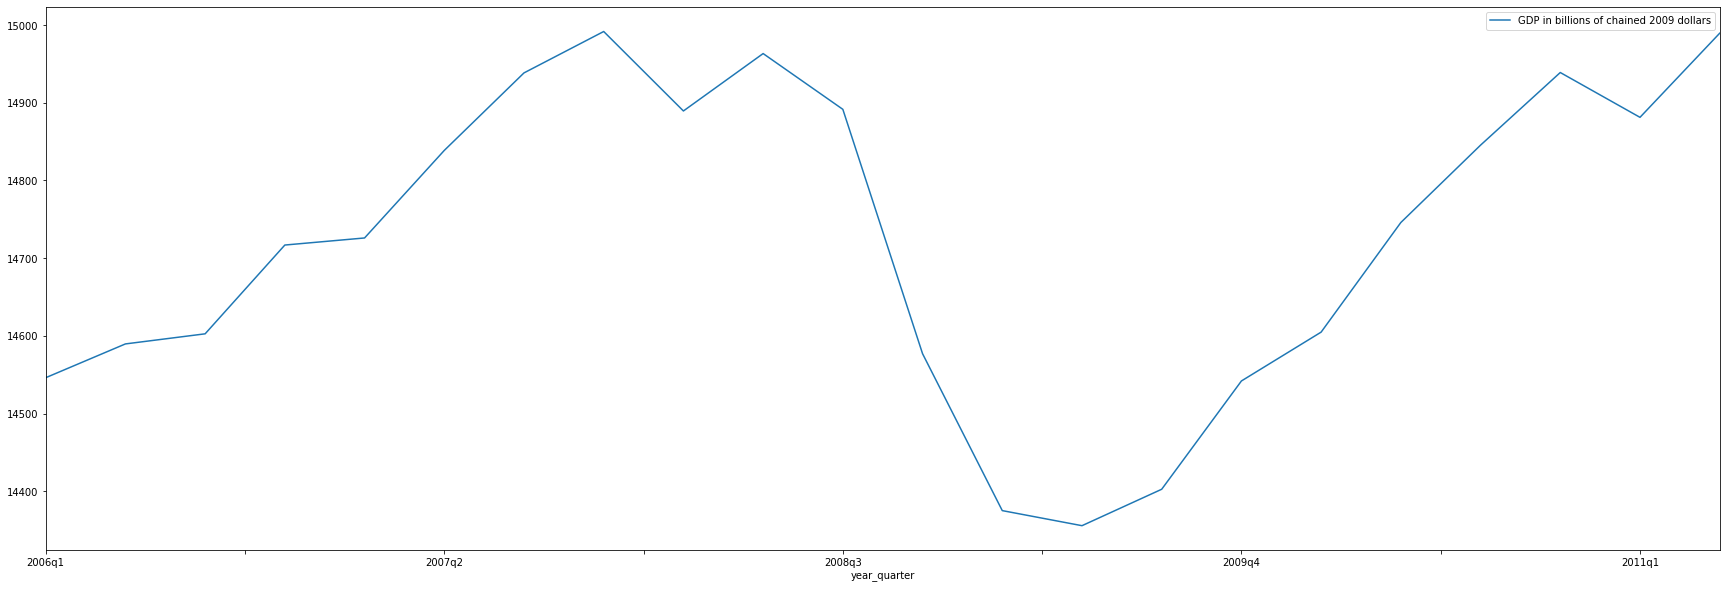

In [36]:
gdp.loc["2006q1":"2011q2"].plot(y = "GDP in billions of chained 2009 dollars",figsize = (30,10))
plt.show()

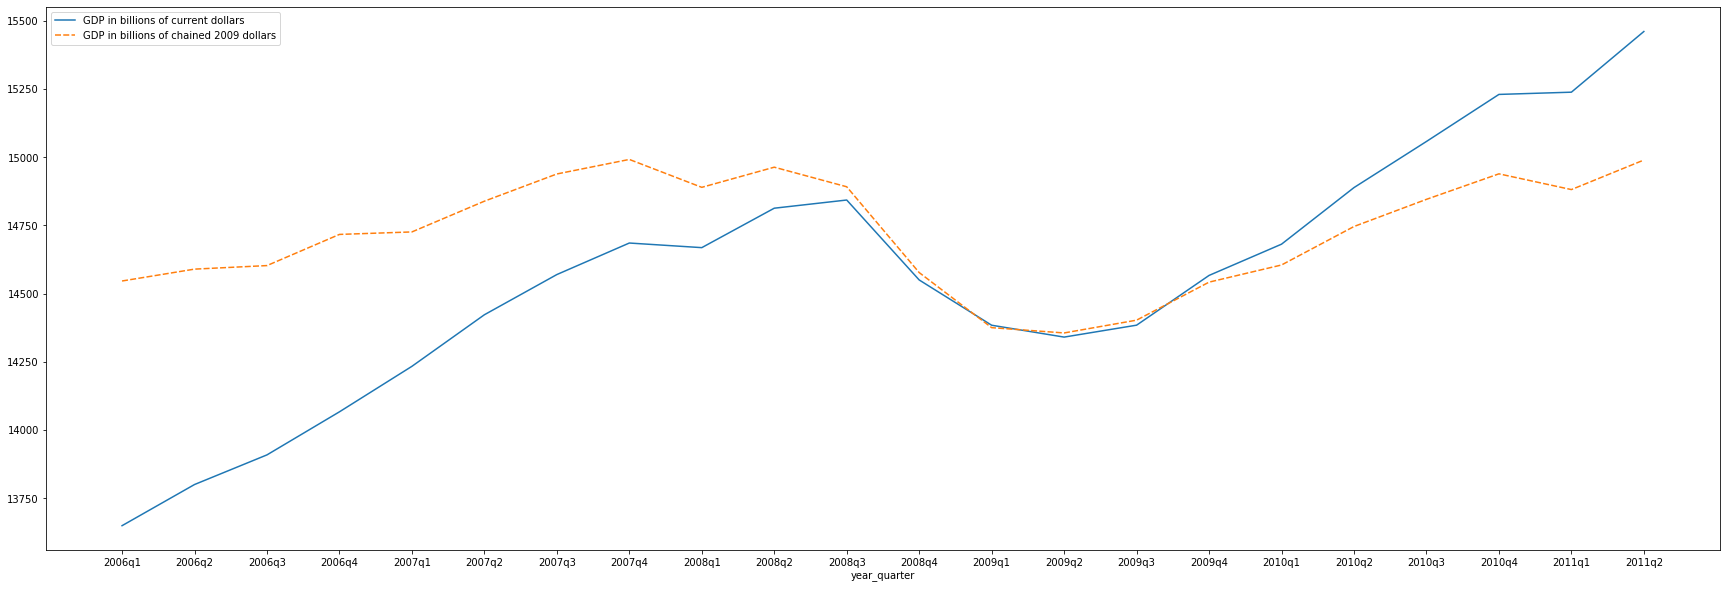

In [37]:
plt.figure(figsize = (30,10))
sns.lineplot(data = gdp.loc["2006q1":"2011q2"])
plt.show()


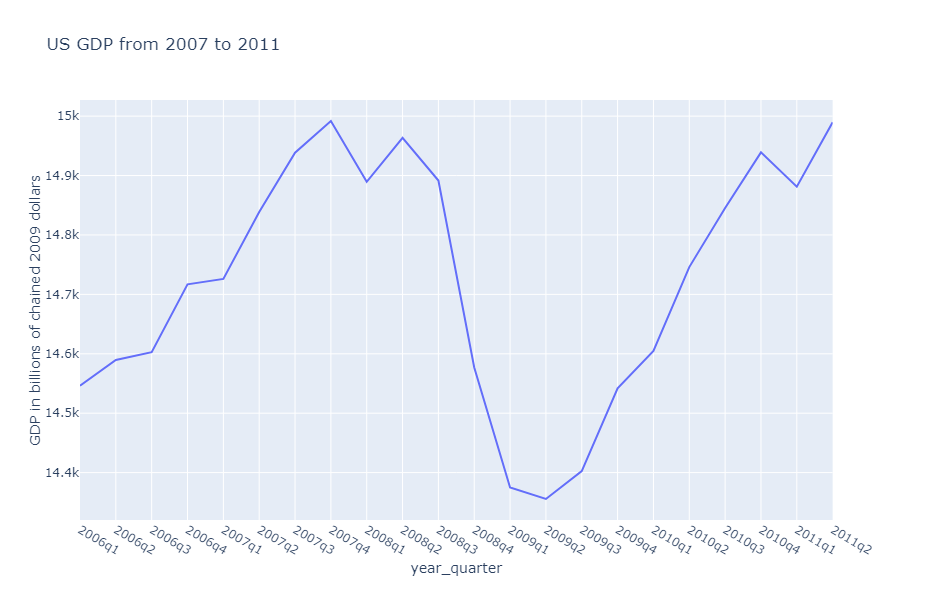

In [53]:
#plt.figure(figsize = (30,10))
px.line(gdp.loc["2006q1":"2011q2"].reset_index(),title = "US GDP from 2007 to 2011",y = "GDP in billions of chained 2009 dollars",x = "year_quarter")

In [ ]:
## recession start - 2008q3
## recession bottom - 2009q2

## Convert the housing data to quarters and returns it as mean values in a dataframe

In [29]:
city_homes["2000q1"] = city_homes.loc[:,"2000-01":"2000-03"].mean(axis = 1)
city_homes["2000q2"] = city_homes.loc[:,"2000-04":"2000-06"].mean(axis = 1)
city_homes["2000q3"] = city_homes.loc[:,"2000-07":"2000-09"].mean(axis = 1)
city_homes["2000q4"] = city_homes.loc[:,"2000-10":"2000-12"].mean(axis = 1)
city_homes["2001q1"] = city_homes.loc[:,"2001-01":"2001-03"].mean(axis = 1)
city_homes["2001q2"] = city_homes.loc[:,"2001-04":"2001-06"].mean(axis = 1)
city_homes["2001q3"] = city_homes.loc[:,"2001-07":"2001-09"].mean(axis = 1)
city_homes["2001q4"] = city_homes.loc[:,"2001-10":"2001-12"].mean(axis = 1)
city_homes["2002q1"] = city_homes.loc[:,"2002-01":"2002-03"].mean(axis = 1)
city_homes["2002q2"] = city_homes.loc[:,"2002-04":"2002-06"].mean(axis = 1)
city_homes["2002q3"] = city_homes.loc[:,"2002-07":"2002-09"].mean(axis = 1)
city_homes["2002q4"] = city_homes.loc[:,"2002-10":"2002-12"].mean(axis = 1)
city_homes["2003q1"] = city_homes.loc[:,"2003-01":"2003-03"].mean(axis = 1)
city_homes["2003q2"] = city_homes.loc[:,"2003-04":"2003-06"].mean(axis = 1)
city_homes["2003q3"] = city_homes.loc[:,"2003-07":"2003-09"].mean(axis = 1)
city_homes["2003q4"] = city_homes.loc[:,"2003-10":"2003-12"].mean(axis = 1)
city_homes["2004q1"] = city_homes.loc[:,"2004-01":"2004-03"].mean(axis = 1)
city_homes["2004q2"] = city_homes.loc[:,"2004-04":"2004-06"].mean(axis = 1)
city_homes["2004q3"] = city_homes.loc[:,"2004-07":"2004-09"].mean(axis = 1)
city_homes["2004q4"] = city_homes.loc[:,"2004-10":"2004-12"].mean(axis = 1)
city_homes["2005q1"] = city_homes.loc[:,"2005-01":"2005-03"].mean(axis = 1)
city_homes["2005q2"] = city_homes.loc[:,"2005-04":"2005-06"].mean(axis = 1)
city_homes["2005q3"] = city_homes.loc[:,"2005-07":"2005-09"].mean(axis = 1)
city_homes["2005q4"] = city_homes.loc[:,"2005-10":"2005-12"].mean(axis = 1)
city_homes["2006q1"] = city_homes.loc[:,"2006-01":"2006-03"].mean(axis = 1)
city_homes["2006q2"] = city_homes.loc[:,"2006-04":"2006-06"].mean(axis = 1)
city_homes["2006q3"] = city_homes.loc[:,"2006-07":"2006-09"].mean(axis = 1)
city_homes["2006q4"] = city_homes.loc[:,"2006-10":"2006-12"].mean(axis = 1)
city_homes["2007q1"] = city_homes.loc[:,"2007-01":"2007-03"].mean(axis = 1)
city_homes["2007q2"] = city_homes.loc[:,"2007-04":"2007-06"].mean(axis = 1)
city_homes["2007q3"] = city_homes.loc[:,"2007-07":"2007-09"].mean(axis = 1)
city_homes["2007q4"] = city_homes.loc[:,"2007-10":"2007-12"].mean(axis = 1)
city_homes["2008q1"] = city_homes.loc[:,"2008-01":"2008-03"].mean(axis = 1)
city_homes["2008q2"] = city_homes.loc[:,"2008-04":"2008-06"].mean(axis = 1)
city_homes["2008q3"] = city_homes.loc[:,"2008-07":"2008-09"].mean(axis = 1)
city_homes["2008q4"] = city_homes.loc[:,"2008-10":"2008-12"].mean(axis = 1)
city_homes["2009q1"] = city_homes.loc[:,"2009-01":"2009-03"].mean(axis = 1)
city_homes["2009q2"] = city_homes.loc[:,"2009-04":"2009-06"].mean(axis = 1)
city_homes["2009q3"] = city_homes.loc[:,"2009-07":"2009-09"].mean(axis = 1)
city_homes["2009q4"] = city_homes.loc[:,"2009-10":"2009-12"].mean(axis = 1)
city_homes["2010q1"] = city_homes.loc[:,"2010-01":"2010-03"].mean(axis = 1)
city_homes["2010q2"] = city_homes.loc[:,"2010-04":"2010-06"].mean(axis = 1)
city_homes["2010q3"] = city_homes.loc[:,"2010-07":"2010-09"].mean(axis = 1)
city_homes["2010q4"] = city_homes.loc[:,"2010-10":"2010-12"].mean(axis = 1)
city_homes["2011q1"] = city_homes.loc[:,"2011-01":"2011-03"].mean(axis = 1)
city_homes["2011q2"] = city_homes.loc[:,"2011-04":"2011-06"].mean(axis = 1)
city_homes["2011q3"] = city_homes.loc[:,"2011-07":"2011-09"].mean(axis = 1)
city_homes["2011q4"] = city_homes.loc[:,"2011-10":"2011-12"].mean(axis = 1)
city_homes["2012q1"] = city_homes.loc[:,"2012-01":"2012-03"].mean(axis = 1)
city_homes["2012q2"] = city_homes.loc[:,"2012-04":"2012-06"].mean(axis = 1)
city_homes["2012q3"] = city_homes.loc[:,"2012-07":"2012-09"].mean(axis = 1)
city_homes["2012q4"] = city_homes.loc[:,"2012-10":"2012-12"].mean(axis = 1)
city_homes["2013q1"] = city_homes.loc[:,"2013-01":"2013-03"].mean(axis = 1)
city_homes["2013q2"] = city_homes.loc[:,"2013-04":"2013-06"].mean(axis = 1)
city_homes["2013q3"] = city_homes.loc[:,"2013-07":"2013-09"].mean(axis = 1)
city_homes["2013q4"] = city_homes.loc[:,"2013-10":"2013-12"].mean(axis = 1)
city_homes["2014q1"] = city_homes.loc[:,"2014-01":"2014-03"].mean(axis = 1)
city_homes["2014q2"] = city_homes.loc[:,"2014-04":"2014-06"].mean(axis = 1)
city_homes["2014q3"] = city_homes.loc[:,"2014-07":"2014-09"].mean(axis = 1)
city_homes["2014q4"] = city_homes.loc[:,"2014-10":"2014-12"].mean(axis = 1)
city_homes["2015q1"] = city_homes.loc[:,"2015-01":"2015-03"].mean(axis = 1)
city_homes["2015q2"] = city_homes.loc[:,"2015-04":"2015-06"].mean(axis = 1)
city_homes["2015q3"] = city_homes.loc[:,"2015-07":"2015-09"].mean(axis = 1)
city_homes["2015q4"] = city_homes.loc[:,"2015-10":"2015-12"].mean(axis = 1)
city_homes["2016q1"] = city_homes.loc[:,"2016-01":"2016-03"].mean(axis = 1)
city_homes["2016q2"] = city_homes.loc[:,"2016-04":"2016-06"].mean(axis = 1)
city_homes["2016q3"] = city_homes.loc[:,"2016-07":"2016-08"].mean(axis = 1)

In [45]:
city_homes.head()

,RegionID,RegionName,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
0,6181,New York,NY,New York,Queens,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,432600.0,438700.0,440500.0,433900.0,422000.0,415700.0,421200.0,431100.0,435100.0,431900.0,428400.0,430700.0,438800.0,446800.0,455400.0,465500.0,472600.0,478200.0,487600.0,498600.0,508800.0,515300.0,517000.0,517800.0,520800.0,521500.0,523000.0,526300.0,524800.0,519100.0,516200.0,516400.0,516300.0,515500.0,512200.0,509200.0,509800.0,511600.0,512700.0,514000.0,513400.0,510700.0,508100.0,506700.0,505200.0,503700.0,502900.0,502400.0,500500.0,496400.0,491900.0,487500.0,484400.0,481700.0,477900.0,473600.0,469700.0,466100.0,461700.0,457700.0,455300.0,454800.0,456000.0,457800.0,461300.0,466100.0,470200.0,472800.0,475300.0,477100.0,478400.0,479100.0,478900.0,477700.0,476700.0,477100.0,478000.0,478000.0,476800.0,475300.0,473800.0,472000.0,470600.0,469900.0,469500.0,468200.0,465800.0,463500.0,461800.0,460100.0,459700.0,460800.0,461700.0,462500.0,463900.0,466000.0,467500.0,468200.0,468700.0,469400.0,469400,469100.0,468700,469300,470300,472100,474300,477600,481400,485100,488800,492600,495900,499500,503500,506400,509900,515700,520800,522200,522400,523800,526200,528400,529600,5308

In [30]:
city_homes.loc[:,"2000q1":"2016q3"] = city_homes.loc[:,"2000q1":"2016q3"].apply(round)

In [51]:
#city_homes.head()

In [48]:
city_homes.shape

(10730, 318)

In [31]:
city_homes_new = pd.concat([city_homes.loc[:,"RegionName":"State"],city_homes.loc[:,"2000q1":"2016q3"]],axis = 1)

In [32]:
city_homes_new.head()

,RegionName,State,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
0,New York,NY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,435650.0,432133.0,422667.0,431800.0,438767.0,464500.0,488133.0,513700.0,520033.0,524700.0,517233.0,514667.0,510200.0,513367.0,508500.0,503933.0,499767.0,487933.0,477733.0,465833.0,455933.0,458367.0,469700.0,476933.0,478567.0,477267.0,476700.0,472133.0,469200.0,463700.0,460200.0,462700.0,467233.0,469167.0,469033.0,472233.0,481367.0,492433.0,503133.0,515467.0,522800.0,528067.0,532267.0,540800.0,557200.0,572833.0,582867.0,591633.0,587200.0
1,Los Angeles,CA,207067.0,214467.0,220967.0,226167.0,233000.0,239100.0,245067.0,253033.0,261967.0,272700.0,287000.0,302233.0,318900.0,334500.0,350633.0,370833.0,395233.0,425567.0,456167.0,477367.0,495067.0,518400.0,545567.0,571067.0,581767.0,587500.0,592967.0,592533.0,591767.0,589500.0,577300.0,561367.0,535300.0,502267.0,469500.0,443967.0,426267.0,413900.0,406367.0,404333.0,413367.0,411167.0,406767.0,402067.0,397100.0,390100.0,382100.0,375567.0,370600.0,375333.0,385567.0,396567.0,411533.0,432867.0,455067.0,471933.0,484267.0,498033.0,509067.0,518867.0,528800.0,538167.0,547267.0,557733.0,566033.0,577467.0,584050.0
2,Chicago,IL,138400.0,143633.0,147867.0,152133.0,156933.0,161800.0,166400.0,170433.0,175500.0,177567.0,178967.0,183700.0,187100.0,194300.0,202067.0,204133.0,206200.0,208600.0,212767.0,218333.0,223900.0,228533.0,233167.0,237500.0,242400.0,245200.0,245700.0,246700.0,247233.0,246400.0,246267.0,246833.0,243733.0,237900.0,232000.0,227033.0,223767.0,219700.0,214100.0,211667.0,207300.0,203800.0,198933.0,191367.0,187400.0,181600.0,174267.0,170200.0,166933.0,167033.0,168133.0,167233.0,168367.0,172633.0,180800.0,185867.0,190900.0,192633.0,195767.0,201267.0,201067.0,206033.0,208300.0,207900.0,206067.0,208200.0,212000.0
3,Philadelphia,PA,53000.0,53633.0,54133.0,54700.0,55333.0,55533.0,56267.0,57533.0,59133.0,60733.0,62167.0,63500.0,64733.0,66200.0,68467.0,70733.0,73733.0,76733.0,80567.0,85533.0,89700.0,94867.0,100167.0,104900.0,108333.0,112367.0,115467.0,116633.0,117333.0,118700.0,120833.0,120800.0,119567.0,118133.0,116933.0,115867.0,116200.0,116167.0,116733.0,118567.0,121167.0,122800.0,120167.0,117767.0,117100.0,116300.0,115467.0,114700.0,112733.0,110533.0,109933.0,110833.0,112000.0,111733.0,111000.0,112467.0,113733.0,113733.0,115300.0,115667.0,116200.0,117967.0,121233.0,122200.0,123433.0,126933.0,128700.0
4,Phoenix,AZ,111833.0,114367.0,116000.0,117400.0,119600.0,121567.0,122700.0,124300.0,126533.0,128367.0,130533.0,133233.0,135700.0,137933.0,139167.0,140433.0,143700.0,147133.0,153200.0,162933.0,174233.0,192667.0,216667.0,234433.0,242800.0,245267.0,245167.0,243533.0,243000.0,239967.0,234800.0,228933.0,218633.0,205267.0,193767.0,183333.0,177567.0,168233.0,155933.0,143467.0,130933.0,126233.0,120767.0,115867.0,113033.0,108000.0,103100.0,103167.0,107500.0,114133.0,123167.0,130433.0,136333.0,144567.0,153400.0,159900.0,163233.0,164267.0,165367.0,168500.0,171533.0,174167.0,179067.0,183833.0,187900.0,191433.0,195200.0


In [55]:
city_homes_new.shape

(10730, 69)

In [33]:
city_homes_new.set_index(["State","RegionName"],inplace = True)

In [53]:
city_homes_new.head()

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
State,RegionName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,435650.0,432133.0,422667.0,431800.0,438767.0,464500.0,488133.0,513700.0,520033.0,524700.0,517233.0,514667.0,510200.0,513367.0,508500.0,503933.0,499767.0,487933.0,477733.0,465833.0,455933.0,458367.0,469700.0,476933.0,478567.0,477267.0,476700.0,472133.0,469200.0,463700.0,460200.0,462700.0,467233.0,469167.0,469033.0,472233.0,481367.0,492433.0,503133.0,515467.0,522800.0,528067.0,532267.0,540800.0,557200.0,572833.0,582867.0,591633.0,587200.0
CA,Los Angeles,207067.0,214467.0,220967.0,226167.0,233000.0,239100.0,245067.0,253033.0,261967.0,272700.0,287000.0,302233.0,318900.0,334500.0,350633.0,370833.0,395233.0,425567.0,456167.0,477367.0,495067.0,518400.0,545567.0,571067.0,581767.0,587500.0,592967.0,592533.0,591767.0,589500.0,577300.0,561367.0,535300.0,502267.0,469500.0,443967.0,426267.0,413900.0,406367.0,404333.0,413367.0,411167.0,406767.0,402067.0,397100.0,390100.0,382100.0,375567.0,370600.0,375333.0,385567.0,396567.0,411533.0,432867.0,455067.0,471933.0,484267.0,498033.0,509067.0,518867.0,528800.0,538167.0,547267.0,557733.0,566033.0,577467.0,584050.0
IL,Chicago,138400.0,143633.0,147867.0,152133.0,156933.0,161800.0,166400.0,170433.0,175500.0,177567.0,178967.0,183700.0,187100.0,194300.0,202067.0,204133.0,206200.0,208600.0,212767.0,218333.0,223900.0,228533.0,233167.0,237500.0,242400.0,245200.0,245700.0,246700.0,247233.0,246400.0,246267.0,246833.0,243733.0,237900.0,232000.0,227033.0,223767.0,219700.0,214100.0,211667.0,207300.0,203800.0,198933.0,191367.0,187400.0,181600.0,174267.0,170200.0,166933.0,167033.0,168133.0,167233.0,168367.0,172633.0,180800.0,185867.0,190900.0,192633.0,195767.0,201267.0,201067.0,206033.0,208300.0,207900.0,206067.0,208200.0,212000.0
PA,Philadelphia,53000.0,53633.0,54133.0,54700.0,55333.0,55533.0,56267.0,57533.0,59133.0,60733.0,62167.0,63500.0,64733.0,66200.0,68467.0,70733.0,73733.0,76733.0,80567.0,85533.0,89700.0,94867.0,100167.0,104900.0,108333.0,112367.0,115467.0,116633.0,117333.0,118700.0,120833.0,120800.0,119567.0,118133.0,116933.0,115867.0,116200.0,116167.0,116733.0,118567.0,121167.0,122800.0,120167.0,117767.0,117100.0,116300.0,115467.0,114700.0,112733.0,110533.0,109933.0,110833.0,112000.0,111733.0,111000.0,112467.0,113733.0,113733.0,115300.0,115667.0,116200.0,117967.0,121233.0,122200.0,123433.0,126933.0,128700.0
AZ,Phoenix,111833.0,114367.0,116000.0,117400.0,119600.0,121567.0,122700.0,124300.0,126533.0,128367.0,130533.0,133233.0,135700.0,137933.0,139167.0,140433.0,143700.0,147133.0,153200.0,162933.0,174233.0,192667.0,216667.0,234433.0,242800.0,245267.0,245167.0,243533.0,243000.0,239967.0,234800.0,228933.0,218633.0,205267.0,193767.0,183333.0,177567.0,168233.0,155933.0,143467.0,130933.0,126233.0,120767.0,115867.0,113033.0,108000.0,103100.0,103167.0,107500.0,114133.0,123167.0,130433.0,136333.0,144567.0,153400.0,159900.0,163233.0,164267.0,165367.0,168500.0,171533.0,174167.0,179067.0,183833.0,187900.0,191433.0,195200.0


In [34]:
city_homes_new.loc[[('OH','Akron'),('OH','Dayton')]].loc[:,['2010q3','2015q2','2016q4']] 

E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:896: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



2010q3   2015q2  2016q4
State RegionName                          
OH    Akron       67567.0  61833.0     NaN
      Dayton      57600.0  50000.0     NaN

In [203]:
city_homes_new.shape

(10730, 67)

In [204]:
univ_towns.head(6)

,State,RegionName,new_State,Univ_Town
0,Alabama,Auburn,AL,Y
1,Alabama,Florence,AL,Y
2,Alabama,Jacksonville,AL,Y
3,Alabama,Livingston,AL,Y
4,Alabama,Montevallo,AL,Y
5,Alabama,Troy,AL,Y


In [35]:
univ_towns.shape

(517, 4)

#### Creates new data showing the decline or growth of housing prices between the recession start and the recession bottom. 
#### Run t-test comparing the university town values to the non-university towns values and returns whether the alternative  hypothesis (that the two groups are the same) is true or not as well as the p-value of the confidence. If the t-test is True at a p<0.01 (we reject the null hypothesis)

In [36]:
city_homes_new['recession_difference'] = city_homes_new['2008q2'] / city_homes_new['2009q2'] #price_ratio=quarter_before_recession/recession_bottom

In [37]:
city_homes_new.reset_index(inplace = True)

In [38]:
city_homes_new.head()

,State,RegionName,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3,recession_difference
0,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,435650.0,432133.0,422667.0,431800.0,438767.0,464500.0,488133.0,513700.0,520033.0,524700.0,517233.0,514667.0,510200.0,513367.0,508500.0,503933.0,499767.0,487933.0,477733.0,465833.0,455933.0,458367.0,469700.0,476933.0,478567.0,477267.0,476700.0,472133.0,469200.0,463700.0,460200.0,462700.0,467233.0,469167.0,469033.0,472233.0,481367.0,492433.0,503133.0,515467.0,522800.0,528067.0,532267.0,540800.0,557200.0,572833.0,582867.0,591633.0,587200.0,1.081789
1,CA,Los Angeles,207067.0,214467.0,220967.0,226167.0,233000.0,239100.0,245067.0,253033.0,261967.0,272700.0,287000.0,302233.0,318900.0,334500.0,350633.0,370833.0,395233.0,425567.0,456167.0,477367.0,495067.0,518400.0,545567.0,571067.0,581767.0,587500.0,592967.0,592533.0,591767.0,589500.0,577300.0,561367.0,535300.0,502267.0,469500.0,443967.0,426267.0,413900.0,406367.0,404333.0,413367.0,411167.0,406767.0,402067.0,397100.0,390100.0,382100.0,375567.0,370600.0,375333.0,385567.0,396567.0,411533.0,432867.0,455067.0,471933.0,484267.0,498033.0,509067.0,518867.0,528800.0,538167.0,547267.0,557733.0,566033.0,577467.0,584050.0,1.213498
2,IL,Chicago,138400.0,143633.0,147867.0,152133.0,156933.0,161800.0,166400.0,170433.0,175500.0,177567.0,178967.0,183700.0,187100.0,194300.0,202067.0,204133.0,206200.0,208600.0,212767.0,218333.0,223900.0,228533.0,233167.0,237500.0,242400.0,245200.0,245700.0,246700.0,247233.0,246400.0,246267.0,246833.0,243733.0,237900.0,232000.0,227033.0,223767.0,219700.0,214100.0,211667.0,207300.0,203800.0,198933.0,191367.0,187400.0,181600.0,174267.0,170200.0,166933.0,167033.0,168133.0,167233.0,168367.0,172633.0,180800.0,185867.0,190900.0,192633.0,195767.0,201267.0,201067.0,206033.0,208300.0,207900.0,206067.0,208200.0,212000.0,1.082840
3,PA,Philadelphia,53000.0,53633.0,54133.0,54700.0,55333.0,55533.0,56267.0,57533.0,59133.0,60733.0,62167.0,63500.0,64733.0,66200.0,68467.0,70733.0,73733.0,76733.0,80567.0,85533.0,89700.0,94867.0,100167.0,104900.0,108333.0,112367.0,115467.0,116633.0,117333.0,118700.0,120833.0,120800.0,119567.0,118133.0,116933.0,115867.0,116200.0,116167.0,116733.0,118567.0,121167.0,122800.0,120167.0,117767.0,117100.0,116300.0,115467.0,114700.0,112733.0,110533.0,109933.0,110833.0,112000.0,111733.0,111000.0,112467.0,113733.0,113733.0,115300.0,115667.0,116200.0,117967.0,121233.0,122200.0,123433.0,126933.0,128700.0,1.016924
4,AZ,Phoenix,111833.0,114367.0,116000.0,117400.0,119600.0,121567.0,122700.0,124300.0,126533.0,128367.0,130533.0,133233.0,135700.0,137933.0,139167.0,140433.0,143700.0,147133.0,153200.0,162933.0,174233.0,192667.0,216667.0,234433.0,242800.0,245267.0,245167.0,243533.0,243000.0,239967.0,234800.0,228933.0,218633.0,205267.0,193767.0,183333.0,177567.0,168233.0,155933.0,143467.0,130933.0,126233.0,120767.0,115867.0,113033.0,108000.0,103100.0,103167.0,107500.0,114133.0,123167.0,130433.0,136333.0,144567.0,153400.0,159900.0,163233.0,164267.0,165367.0,168500.0,171533.0,174167.0,179067.0,183833.0,187900.0,191433.0,195200.0,1.220135


In [209]:
city_homes_new['RegionName'].value_counts()

Springfield     15
Middletown      13
Jackson         12
Washington      12
Clinton         12
                ..
Lake Stevens     1
Bloomer          1
Sacramento       1
Blue Springs     1
Grand Ridge      1
Name: RegionName, Length: 8258, dtype: int64

In [52]:
#city_homes_new.loc[city_homes_new['RegionName'] == "Springfield",:]

In [210]:
len(set(city_homes_new['RegionName']) & set(univ_towns['RegionName']))

355

In [212]:
len(set(city_homes_new['State']) & set(univ_towns['new_State']))

49

In [40]:
combined_df = pd.merge(city_homes_new,univ_towns,left_on =  ['RegionName','State'],right_on = ['RegionName','new_State'],how = 'left')
combined_df.head(10)

,State_x,RegionName,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3,recession_difference,State_y,new_State,Univ_Town
0,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,435650.0,432133.0,422667.0,431800.0,438767.0,464500.0,488133.0,513700.0,520033.0,524700.0,517233.0,514667.0,510200.0,513367.0,508500.0,503933.0,499767.0,487933.0,477733.0,465833.0,455933.0,458367.0,469700.0,476933.0,478567.0,477267.0,476700.0,472133.0,469200.0,463700.0,460200.0,462700.0,467233.0,469167.0,469033.0,472233.0,481367.0,492433.0,503133.0,515467.0,522800.0,528067.0,532267.0,540800.0,557200.0,572833.0,582867.0,591633.0,587200.0,1.081789,NaN,NaN,NaN
1,CA,Los Angeles,207067.0,214467.0,220967.0,226167.0,233000.0,239100.0,245067.0,253033.0,261967.0,272700.0,287000.0,302233.0,318900.0,334500.0,350633.0,370833.0,395233.0,425567.0,456167.0,477367.0,495067.0,518400.0,545567.0,571067.0,581767.0,587500.0,592967.0,592533.0,591767.0,589500.0,577300.0,561367.0,535300.0,502267.0,469500.0,443967.0,426267.0,413900.0,406367.0,404333.0,413367.0,411167.0,406767.0,402067.0,397100.0,390100.0,382100.0,375567.0,370600.0,375333.0,385567.0,396567.0,411533.0,432867.0,455067.0,471933.0,484267.0,498033.0,509067.0,518867.0,528800.0,538167.0,547267.0,557733.0,566033.0,577467.0,584050.0,1.213498,NaN,NaN,NaN
2,IL,Chicago,138400.0,143633.0,147867.0,152133.0,156933.0,161800.0,166400.0,170433.0,175500.0,177567.0,178967.0,183700.0,187100.0,194300.0,202067.0,204133.0,206200.0,208600.0,212767.0,218333.0,223900.0,228533.0,233167.0,237500.0,242400.0,245200.0,245700.0,246700.0,247233.0,246400.0,246267.0,246833.0,243733.0,237900.0,232000.0,227033.0,223767.0,219700.0,214100.0,211667.0,207300.0,203800.0,198933.0,191367.0,187400.0,181600.0,174267.0,170200.0,166933.0,167033.0,168133.0,167233.0,168367.0,172633.0,180800.0,185867.0,190900.0,192633.0,195767.0,201267.0,201067.0,206033.0,208300.0,207900.0,206067.0,208200.0,212000.0,1.082840,NaN,NaN,NaN
3,PA,Philadelphia,53000.0,53633.0,54133.0,54700.0,55333.0,55533.0,56267.0,57533.0,59133.0,60733.0,62167.0,63500.0,64733.0,66200.0,68467.0,70733.0,73733.0,76733.0,80567.0,85533.0,89700.0,94867.0,100167.0,104900.0,108333.0,112367.0,115467.0,116633.0,117333.0,118700.0,120833.0,120800.0,119567.0,118133.0,116933.0,115867.0,116200.0,116167.0,116733.0,118567.0,121167.0,122800.0,120167.0,117767.0,117100.0,116300.0,115467.0,114700.0,112733.0,110533.0,109933.0,110833.0,112000.0,111733.0,111000.0,112467.0,113733.0,113733.0,115300.0,115667.0,116200.0,117967.0,121233.0,122200.0,123433.0,126933.0,128700.0,1.016924,NaN,NaN,NaN
4,AZ,Phoenix,111833.0,114367.0,116000.0,117400.0,119600.0,121567.0,122700.0,124300.0,126533.0,128367.0,130533.0,133233.0,135700.0,137933.0,139167.0,140433.0,143700.0,147133.0,153200.0,162933.0,174233.0,192667.0,216667.0,234433.0,242800.0,245267.0,245167.0,243533.0,243000.0,239967.0,234800.0,228933.0,218633.0,205267.0,193767.0,183333.0,177567.0,168233.0,155933.0,143467.0,130933.0,126233.0,120767.0,115867.0,113033.0,108000.0,103100.0,103167.0,107500.0,114133.0,123167.0,130433.0,136333.0,144567.0,153400.0,159900.0,163233.0,164267.0,165367.0,168500.0,171533.0,174167.0,179067.0,183833.0,187900.0,191433.0,195200.0,1.220135,NaN,NaN,NaN
5,NV,Las Vegas,132600.0,134367.0,135400.0,137000.0,139533.0,141733.0,143367.0,146133.0,149333.0,150933.0,152333.0,155400.0,159467.0,162667.0,167333.0,176167.0,190067.0,215967.0,246400.0,262800.0,269000.0,274767.0,280500.0,288667.0,295433.0,297733.0,297533.0,294333.0,289967.0,282100.0,274967.0,264933.0,250933.0,232300.0,213367.0,194933.0,181200.0,164333.0,146233.0,136133.0,1294

In [41]:
combined_df['Univ_Town'].fillna("N",inplace = True)

In [42]:
combined_df.head()

,State_x,RegionName,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3,recession_difference,State_y,new_State,Univ_Town
0,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,435650.0,432133.0,422667.0,431800.0,438767.0,464500.0,488133.0,513700.0,520033.0,524700.0,517233.0,514667.0,510200.0,513367.0,508500.0,503933.0,499767.0,487933.0,477733.0,465833.0,455933.0,458367.0,469700.0,476933.0,478567.0,477267.0,476700.0,472133.0,469200.0,463700.0,460200.0,462700.0,467233.0,469167.0,469033.0,472233.0,481367.0,492433.0,503133.0,515467.0,522800.0,528067.0,532267.0,540800.0,557200.0,572833.0,582867.0,591633.0,587200.0,1.081789,NaN,NaN,N
1,CA,Los Angeles,207067.0,214467.0,220967.0,226167.0,233000.0,239100.0,245067.0,253033.0,261967.0,272700.0,287000.0,302233.0,318900.0,334500.0,350633.0,370833.0,395233.0,425567.0,456167.0,477367.0,495067.0,518400.0,545567.0,571067.0,581767.0,587500.0,592967.0,592533.0,591767.0,589500.0,577300.0,561367.0,535300.0,502267.0,469500.0,443967.0,426267.0,413900.0,406367.0,404333.0,413367.0,411167.0,406767.0,402067.0,397100.0,390100.0,382100.0,375567.0,370600.0,375333.0,385567.0,396567.0,411533.0,432867.0,455067.0,471933.0,484267.0,498033.0,509067.0,518867.0,528800.0,538167.0,547267.0,557733.0,566033.0,577467.0,584050.0,1.213498,NaN,NaN,N
2,IL,Chicago,138400.0,143633.0,147867.0,152133.0,156933.0,161800.0,166400.0,170433.0,175500.0,177567.0,178967.0,183700.0,187100.0,194300.0,202067.0,204133.0,206200.0,208600.0,212767.0,218333.0,223900.0,228533.0,233167.0,237500.0,242400.0,245200.0,245700.0,246700.0,247233.0,246400.0,246267.0,246833.0,243733.0,237900.0,232000.0,227033.0,223767.0,219700.0,214100.0,211667.0,207300.0,203800.0,198933.0,191367.0,187400.0,181600.0,174267.0,170200.0,166933.0,167033.0,168133.0,167233.0,168367.0,172633.0,180800.0,185867.0,190900.0,192633.0,195767.0,201267.0,201067.0,206033.0,208300.0,207900.0,206067.0,208200.0,212000.0,1.082840,NaN,NaN,N
3,PA,Philadelphia,53000.0,53633.0,54133.0,54700.0,55333.0,55533.0,56267.0,57533.0,59133.0,60733.0,62167.0,63500.0,64733.0,66200.0,68467.0,70733.0,73733.0,76733.0,80567.0,85533.0,89700.0,94867.0,100167.0,104900.0,108333.0,112367.0,115467.0,116633.0,117333.0,118700.0,120833.0,120800.0,119567.0,118133.0,116933.0,115867.0,116200.0,116167.0,116733.0,118567.0,121167.0,122800.0,120167.0,117767.0,117100.0,116300.0,115467.0,114700.0,112733.0,110533.0,109933.0,110833.0,112000.0,111733.0,111000.0,112467.0,113733.0,113733.0,115300.0,115667.0,116200.0,117967.0,121233.0,122200.0,123433.0,126933.0,128700.0,1.016924,NaN,NaN,N
4,AZ,Phoenix,111833.0,114367.0,116000.0,117400.0,119600.0,121567.0,122700.0,124300.0,126533.0,128367.0,130533.0,133233.0,135700.0,137933.0,139167.0,140433.0,143700.0,147133.0,153200.0,162933.0,174233.0,192667.0,216667.0,234433.0,242800.0,245267.0,245167.0,243533.0,243000.0,239967.0,234800.0,228933.0,218633.0,205267.0,193767.0,183333.0,177567.0,168233.0,155933.0,143467.0,130933.0,126233.0,120767.0,115867.0,113033.0,108000.0,103100.0,103167.0,107500.0,114133.0,123167.0,130433.0,136333.0,144567.0,153400.0,159900.0,163233.0,164267.0,165367.0,168500.0,171533.0,174167.0,179067.0,183833.0,187900.0,191433.0,195200.0,1.220135,NaN,NaN,N


In [43]:
combined_df.shape

(10730, 73)

In [45]:
#combined_df.isnull().sum()

In [2]:
#combined_df.loc[(combined_df["2008q2"].isnull()) & (combined_df["2009q2"].isnull())]

In [46]:
univtowns_medianprice = combined_df.loc[combined_df['Univ_Town'] == "Y",:]
non_univtowns_medianprice = combined_df.loc[combined_df['Univ_Town'] == "N",:]

In [47]:
univtowns_medianprice.shape 

(269, 73)

In [48]:
non_univtowns_medianprice.shape 

(10461, 73)

In [223]:
univtowns_medianprice.head(10)

,State_x,RegionName,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3,recession_difference,State_y,new_State,Univ_Town
5,NV,Las Vegas,132600.0,134367.0,135400.0,137000.0,139533.0,141733.0,143367.0,146133.0,149333.0,150933.0,152333.0,155400.0,159467.0,162667.0,167333.0,176167.0,190067.0,215967.0,246400.0,262800.0,269000.0,274767.0,280500.0,288667.0,295433.0,297733.0,297533.0,294333.0,289967.0,282100.0,274967.0,264933.0,250933.0,232300.0,213367.0,194933.0,181200.0,164333.0,146233.0,136133.0,129467.0,128433.0,125967.0,123800.0,120600.0,115833.0,112167.0,110400.0,110867.0,113233.0,118567.0,124767.0,132633.0,142333.0,154600.0,162567.0,166000.0,170067.0,173400.0,175467.0,177500.0,181600.0,186767.0,190633.0,194600.0,197200.0,199950.0,1.413593,Nevada,NV,Y
6,CA,San Diego,222900.0,234367.0,245433.0,256033.0,267200.0,276267.0,284500.0,291933.0,301233.0,312867.0,331100.0,350700.0,366433.0,377433.0,389600.0,412033.0,440067.0,476033.0,511033.0,525133.0,531233.0,536333.0,539833.0,542733.0,541500.0,538367.0,527867.0,517900.0,512833.0,505300.0,493900.0,481167.0,461967.0,441400.0,424667.0,407633.0,395700.0,389500.0,391500.0,398567.0,406133.0,406133.0,398133.0,389667.0,383600.0,376100.0,369000.0,366567.0,369767.0,376733.0,387000.0,401967.0,416400.0,435667.0,454800.0,466467.0,474000.0,480200.0,489033.0,496433.0,503367.0,512067.0,519767.0,525467.0,529333.0,536233.0,539750.0,1.133248,California,CA,Y
7,TX,Dallas,84467.0,83867.0,84867.0,87833.0,89733.0,89300.0,89067.0,90900.0,92567.0,93800.0,95400.0,96500.0,98200.0,98500.0,99133.0,99967.0,102700.0,107733.0,110400.0,111900.0,114033.0,115867.0,116667.0,117567.0,117867.0,118533.0,119900.0,121100.0,121333.0,121767.0,122567.0,123133.0,119900.0,115367.0,112167.0,109900.0,107667.0,105100.0,104400.0,103433.0,103300.0,102733.0,100567.0,98333.0,97200.0,95300.0,93933.0,93833.0,96167.0,97767.0,97633.0,97700.0,97967.0,100267.0,102233.0,104533.0,105333.0,106633.0,108900.0,111533.0,113700.0,121133.0,128567.0,134600.0,140500.0,144600.0,149300.0,1.097688,Texas,TX,Y
11,TX,Austin,142967.0,145267.0,149467.0,155733.0,161233.0,160733.0,159533.0,160033.0,158967.0,157500.0,156033.0,154133.0,153200.0,154233.0,155467.0,155700.0,158633.0,162300.0,164333.0,165100.0,167000.0,169667.0,172400.0,176867.0,180367.0,184233.0,188667.0,192700.0,197967.0,203033.0,209933.0,214533.0,215900.0,213733.0,211033.0,207467.0,207000.0,204000.0,207067.0,214167.0,207067.0,206467.0,202267.0,198933.0,200100.0,200233.0,198333.0,198533.0,202867.0,205600.0,209300.0,210633.0,213433.0,220867.0,229000.0,235267.0,243533.0,248867.0,252800.0,258133.0,266500.0,275033.0,281633.0,287233.0,293500.0,301433.0,304450.0,1.047711,Texas,TX,Y
13,OH,Columbus,94367.0,95833.0,97133.0,98267.0,99400.0,100267.0,101067.0,102200.0,103400.0,104800.0,106367.0,107700.0,109300.0,110800.0,112433.0,113533.0,114400.0,115200.0,116467.0,118400.0,119433.0,120567.0,120833.0,121533.0,121767.0,122133.0,121433.0,120500.0,120300.0,119733.0,119267.0,118733.0,116633.0,113500.0,112200.0,111600.0,110967.0,109767.0,108700.0,109333.0,110900.0,109467.0,108133.0,105300.0,103267.0,102233.0,99800.0,96200.0,94367.0,95667.0,96467.0,95800.0,95000.0,96767.0,98933.0,100767.0,101733.0,103133.0,104500.0,106433.0,107867.0,109433.0,111567.0,115000.0,116700.0,118200.0,120100.0,1.034008,Ohio,OH,Y
14,TN,Memphis,72500.0,73200.0,73867.0,74000.0,74167.0,74933.0,75500.0,76067.0,76333.0,76767.0,77400.0,78067.0,78533.0,78933.0,79267.0,79533.0,80367.0,80633.0,81167.0,81900.0,82600.0,83500.0,84267.0,85267.0,86167.0,87167.0,87600.0,88633.0,89633.0,89367.0,87933.0,86600.0,85600.0,84400.0,83700.0,80900.0,77967.0,76

In [224]:
univtowns_medianprice['recession_difference'].isnull().sum()

12

In [225]:
non_univtowns_medianprice['recession_difference'].isnull().sum()

862

In [49]:
non_univtowns_medianprice.head()

,State_x,RegionName,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3,recession_difference,State_y,new_State,Univ_Town
0,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,435650.0,432133.0,422667.0,431800.0,438767.0,464500.0,488133.0,513700.0,520033.0,524700.0,517233.0,514667.0,510200.0,513367.0,508500.0,503933.0,499767.0,487933.0,477733.0,465833.0,455933.0,458367.0,469700.0,476933.0,478567.0,477267.0,476700.0,472133.0,469200.0,463700.0,460200.0,462700.0,467233.0,469167.0,469033.0,472233.0,481367.0,492433.0,503133.0,515467.0,522800.0,528067.0,532267.0,540800.0,557200.0,572833.0,582867.0,591633.0,587200.0,1.081789,NaN,NaN,N
1,CA,Los Angeles,207067.0,214467.0,220967.0,226167.0,233000.0,239100.0,245067.0,253033.0,261967.0,272700.0,287000.0,302233.0,318900.0,334500.0,350633.0,370833.0,395233.0,425567.0,456167.0,477367.0,495067.0,518400.0,545567.0,571067.0,581767.0,587500.0,592967.0,592533.0,591767.0,589500.0,577300.0,561367.0,535300.0,502267.0,469500.0,443967.0,426267.0,413900.0,406367.0,404333.0,413367.0,411167.0,406767.0,402067.0,397100.0,390100.0,382100.0,375567.0,370600.0,375333.0,385567.0,396567.0,411533.0,432867.0,455067.0,471933.0,484267.0,498033.0,509067.0,518867.0,528800.0,538167.0,547267.0,557733.0,566033.0,577467.0,584050.0,1.213498,NaN,NaN,N
2,IL,Chicago,138400.0,143633.0,147867.0,152133.0,156933.0,161800.0,166400.0,170433.0,175500.0,177567.0,178967.0,183700.0,187100.0,194300.0,202067.0,204133.0,206200.0,208600.0,212767.0,218333.0,223900.0,228533.0,233167.0,237500.0,242400.0,245200.0,245700.0,246700.0,247233.0,246400.0,246267.0,246833.0,243733.0,237900.0,232000.0,227033.0,223767.0,219700.0,214100.0,211667.0,207300.0,203800.0,198933.0,191367.0,187400.0,181600.0,174267.0,170200.0,166933.0,167033.0,168133.0,167233.0,168367.0,172633.0,180800.0,185867.0,190900.0,192633.0,195767.0,201267.0,201067.0,206033.0,208300.0,207900.0,206067.0,208200.0,212000.0,1.082840,NaN,NaN,N
3,PA,Philadelphia,53000.0,53633.0,54133.0,54700.0,55333.0,55533.0,56267.0,57533.0,59133.0,60733.0,62167.0,63500.0,64733.0,66200.0,68467.0,70733.0,73733.0,76733.0,80567.0,85533.0,89700.0,94867.0,100167.0,104900.0,108333.0,112367.0,115467.0,116633.0,117333.0,118700.0,120833.0,120800.0,119567.0,118133.0,116933.0,115867.0,116200.0,116167.0,116733.0,118567.0,121167.0,122800.0,120167.0,117767.0,117100.0,116300.0,115467.0,114700.0,112733.0,110533.0,109933.0,110833.0,112000.0,111733.0,111000.0,112467.0,113733.0,113733.0,115300.0,115667.0,116200.0,117967.0,121233.0,122200.0,123433.0,126933.0,128700.0,1.016924,NaN,NaN,N
4,AZ,Phoenix,111833.0,114367.0,116000.0,117400.0,119600.0,121567.0,122700.0,124300.0,126533.0,128367.0,130533.0,133233.0,135700.0,137933.0,139167.0,140433.0,143700.0,147133.0,153200.0,162933.0,174233.0,192667.0,216667.0,234433.0,242800.0,245267.0,245167.0,243533.0,243000.0,239967.0,234800.0,228933.0,218633.0,205267.0,193767.0,183333.0,177567.0,168233.0,155933.0,143467.0,130933.0,126233.0,120767.0,115867.0,113033.0,108000.0,103100.0,103167.0,107500.0,114133.0,123167.0,130433.0,136333.0,144567.0,153400.0,159900.0,163233.0,164267.0,165367.0,168500.0,171533.0,174167.0,179067.0,183833.0,187900.0,191433.0,195200.0,1.220135,NaN,NaN,N


In [236]:
from scipy import stats

In [228]:
## two sample t-test for difference of 2 means (mean of all univ towns and non univ towns)
stats.ttest_ind(univtowns_medianprice['recession_difference'].dropna(), non_univtowns_medianprice['recession_difference'].dropna()) ## have to drop na values or else NaN will be result

Ttest_indResult(statistic=-2.9980257384398143, pvalue=0.002724125553167241)

In [229]:
univtowns_medianprice['recession_difference'].mean() ## university towns is better

1.0545646181587893

In [230]:
non_univtowns_medianprice['recession_difference'].mean()

1.0751962650117424